### Bibliotecas

In [2]:
import pandas as pd
from datetime import datetime, date
from matplotlib import pyplot as plt
from scipy import stats
from patsy import dmatrices
from catboost import CatBoostRegressor, CatBoostClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, confusion_matrix, classification_report
from sklearn.preprocessing import MinMaxScaler
from math import sqrt
import seaborn as sns
import numpy as np
import warnings
warnings.filterwarnings("ignore")

### Importação dos Dados e Criação de Variáveis

In [4]:
dataset_dados = pd.read_excel('botafogo_previsao_estadio.xlsx')

In [5]:
dataset_dados = dataset_dados.sort_values(by='data').reset_index(drop=True)

##### Datas

In [7]:
dataset_dados['data'] = pd.to_datetime(dataset_dados['data'])

In [8]:
dataset_dados['horario'] = dataset_dados['horario'].fillna('99:99:99')

In [9]:
dataset_dados = dataset_dados.assign(dia_semana=dataset_dados['data'].dt.weekday, hora=dataset_dados['horario'].astype('str').str.slice(stop=2).astype('int').replace({99:np.nan}),
                     minuto=dataset_dados['horario'].astype('str').str.slice(start=3, stop=5).astype('int').replace({99:np.nan}))
dataset_dados['horario'] = dataset_dados['horario'].replace({'99:99:99':np.nan})

In [10]:
dataset_dados['mes'] = dataset_dados['data'].dt.month

In [11]:
dataset_dados['dia_mes'] = dataset_dados['data'].dt.day

##### Resultados de Jogos

In [13]:
dataset_dados['resultado_temporario'] = dataset_dados['gols_mandante'] - dataset_dados['gols_visitantes']

In [14]:
dataset_dados = dataset_dados.assign(resultado_partida=dataset_dados['resultado_temporario'].map(lambda x: 0 if x == 0 else 1 if x > 0 else -1))

In [15]:
dataset_dados.loc[dataset_dados[
    (dataset_dados['time_mandante'] != 'Botafogo') &
    (dataset_dados['resultado_partida'] == 1)
].index, 'resultado_partida'] = -1

In [16]:
dataset_dados.loc[dataset_dados[
    (dataset_dados['time_mandante'] != 'Botafogo') &
    (dataset_dados['resultado_partida'] == -1)
].index, 'resultado_partida'] = 1

Resultados Consecutivos

    Olhando para os últimos 5 jogos como vem sendo o "momento" do time:
        Vitória: 1 ponto
        Empate: 0 ponto
        Derrota: -1 ponto
        
    Valor Máximo: 5 pontos
    Valor Mínimo: -5 pontos

In [18]:
#RESULTADOS CONSECUTIVOS

dataset_consec = dataset_dados['resultado_partida'].shift(5, fill_value=0)

for i in range(len(dataset_dados)):
    valor = dataset_consec[i:5+i].sum()
    dataset_dados.loc[i, 'resultados_consecutivos'] = valor
    
#RESULTADO ÚLTIMO JOGO

dataset_ultimo = dataset_dados['resultado_partida'].shift(1, fill_value=0)

for i in range(len(dataset_dados)):
    valor = dataset_ultimo[i:5+i].sum()
    dataset_dados.loc[i, 'resultados_ultimo_jogo'] = valor

del dataset_consec, dataset_ultimo

##### Gols, Colocação e Time Adversário

In [20]:
dataset_dados.loc[:,['gols_botafogo','colocacao_botafogo','colocacao_adversario','time_adversario']] = dataset_dados.apply(lambda d: d[['gols_mandante','colocacao_mandante','colocacao_visitante','time_visitante']].rename(index={'gols_mandante':'gols_botafogo','colocacao_mandante':'colocacao_botafogo','colocacao_visitante':'colocacao_adversario','time_visitante':'time_adversario'})
                            if d['time_mandante'] == 'Botafogo' 
                            else d[['gols_visitantes','colocacao_visitante','colocacao_mandante','time_mandante']].rename(index={'gols_visitantes':'gols_botafogo','colocacao_visitante':'colocacao_botafogo','colocacao_mandante':'colocacao_adversario','time_mandante':'time_adversario'}), axis=1)

In [21]:
dataset_gols = dataset_dados['gols_botafogo'].shift(5, fill_value=0)
for i in range(len(dataset_dados)):
    valor = dataset_gols[i+0:5+i].sum()
    dataset_dados.loc[i, 'gols_botafogo_ultimos_jogos'] = valor
del dataset_gols

##### Percentual de Ocupacao

In [23]:
dataset_dados['percentual_ocupacao'] = round((dataset_dados['publico'] / dataset_dados['publico_max']) * 100, 2)

##### Jogos de Mando Vendido ou Compartilhado

In [25]:
dados_mando_vendido = dataset_dados[(dataset_dados['resultado_financeiro'] != dataset_dados['custo_botafogo'])]
index = dados_mando_vendido[~dados_mando_vendido['custo_botafogo'].isnull()].index

In [26]:
dataset_dados['mando_vendido_compartilhado'] = False
dataset_dados.loc[index, 'mando_vendido_compartilhado'] = True

##### Prejuízo ou Lucro

In [28]:
index = dataset_dados[dataset_dados['custo_botafogo'] <= 0].index
dataset_dados.loc[index, 'prejuizo_lucro'] = False
index = dataset_dados[dataset_dados['custo_botafogo'] > 0].index
dataset_dados.loc[index, 'prejuizo_lucro'] = True

Competições Internacionais não possuem o borderô publicado a partir de certa data, portanto vamos considerar uma regra:

    Nunca houve prejuízo em jogos com 900000 reais de arrecadação

In [30]:
index = dataset_dados[(dataset_dados['custo_botafogo'].isnull()) &
              (dataset_dados['arrecadacao'] < 900000)
             ].index
dataset_dados.loc[index, 'prejuizo_lucro'] = False
index = dataset_dados[(dataset_dados['custo_botafogo'].isnull()) &
              (dataset_dados['arrecadacao'] >= 900000)
             ].index
dataset_dados.loc[index, 'prejuizo_lucro'] = True

### Dados Usáveis para o Modelo e Tratamentos

In [32]:
dataset_dados = dataset_dados[dataset_dados['time_mandante'] == 'Botafogo']
dataset_dados = dataset_dados.reset_index(drop=True)

##### Distância dos Dias entre o Último Jogo em Casa

In [34]:
dataset_dados['data_ultimo_jogo'] = dataset_dados['data'].shift(1)

In [35]:
dataset_dados.loc[0,'data_ultimo_jogo'] = pd.to_datetime('2022-03-07')

In [36]:
dataset_dados.loc[:, 'dias_ultimo_jogo_casa'] = (dataset_dados['data'] - dataset_dados['data_ultimo_jogo']).dt.days

##### Tratamentos

In [38]:
len(dataset_dados)

93

In [39]:
dataset_dados.columns

Index(['ano_campeonato', 'campeonato', 'fase', 'estádio', 'data', 'horario',
       'temperatura', 'jogos_no_mes', 'rodada', 'tipo_partida', 'publico',
       'publico_max', 'arrecadacao', 'despesas', 'impostos',
       'resultado_financeiro', 'custo_botafogo', 'anunciou_poupar',
       'time_mandante', 'time_visitante', 'estado_adversario', 'classico',
       'eliminatorio', 'tecnico_botafogo', 'desfalques', 'colocacao_mandante',
       'colocacao_visitante', 'gols_mandante', 'gols_visitantes', 'dia_semana',
       'hora', 'minuto', 'mes', 'dia_mes', 'resultado_temporario',
       'resultado_partida', 'resultados_consecutivos',
       'resultados_ultimo_jogo', 'gols_botafogo', 'colocacao_botafogo',
       'colocacao_adversario', 'time_adversario',
       'gols_botafogo_ultimos_jogos', 'percentual_ocupacao',
       'mando_vendido_compartilhado', 'prejuizo_lucro', 'data_ultimo_jogo',
       'dias_ultimo_jogo_casa'],
      dtype='object')

In [40]:
dataset_dados = dataset_dados.drop(columns=['resultado_temporario', 'gols_visitantes', 'gols_mandante',
                                           'colocacao_visitante', 'colocacao_mandante', 'time_visitante', 'time_mandante',
                                           'custo_botafogo', 'resultado_financeiro', 'impostos', 'despesas', 'arrecadacao',
                                            'publico_max', 'publico', 'gols_botafogo', 'horario', 'data_ultimo_jogo'])

In [41]:
dataset_dados.columns

Index(['ano_campeonato', 'campeonato', 'fase', 'estádio', 'data',
       'temperatura', 'jogos_no_mes', 'rodada', 'tipo_partida',
       'anunciou_poupar', 'estado_adversario', 'classico', 'eliminatorio',
       'tecnico_botafogo', 'desfalques', 'dia_semana', 'hora', 'minuto', 'mes',
       'dia_mes', 'resultado_partida', 'resultados_consecutivos',
       'resultados_ultimo_jogo', 'colocacao_botafogo', 'colocacao_adversario',
       'time_adversario', 'gols_botafogo_ultimos_jogos', 'percentual_ocupacao',
       'mando_vendido_compartilhado', 'prejuizo_lucro',
       'dias_ultimo_jogo_casa'],
      dtype='object')

In [42]:
dataset_dados.loc[dataset_dados[dataset_dados['anunciou_poupar'] == 'SIM'].index, 'anunciou_poupar'] = True
dataset_dados.loc[dataset_dados[dataset_dados['anunciou_poupar'].isnull()].index, 'anunciou_poupar'] = False
dataset_dados.loc[dataset_dados[dataset_dados['classico'] == 'SIM'].index, 'classico'] = True
dataset_dados.loc[dataset_dados[dataset_dados['classico'].isnull()].index, 'classico'] = False
dataset_dados.loc[dataset_dados[dataset_dados['eliminatorio'] == 'SIM'].index, 'eliminatorio'] = True
dataset_dados.loc[dataset_dados[dataset_dados['eliminatorio'].isnull()].index, 'eliminatorio'] = False

In [43]:
len(dataset_dados.columns)

31

In [44]:
dataset_dados = pd.get_dummies(dataset_dados, columns=['campeonato', 'estádio', 'tipo_partida', 'estado_adversario',
                                                       'tecnico_botafogo', 'time_adversario', 'fase'])

In [45]:
dataset_dados = dataset_dados.astype({'anunciou_poupar': bool,
                                      'classico': bool,
                                      'eliminatorio': bool,
                                       'prejuizo_lucro': bool
                                     })

In [46]:
dataset_previsao = dataset_dados[dataset_dados['data'] >= pd.to_datetime(date.today())]
dataset_dados = dataset_dados[dataset_dados['data'] < pd.to_datetime(date.today())]
dataset_dados = dataset_dados.drop(columns=['data'])
dataset_previsao = dataset_previsao.drop(columns=['data'])
dataset_dados = dataset_dados.reset_index(drop=True)

In [47]:
len(dataset_dados)

84

##### Normalizações com Substituição por IQR e Box-Cox

In [49]:
listaColunas = ['ano_campeonato', 'temperatura', 'jogos_no_mes', 'rodada', 'desfalques', 'dia_semana', 'hora', 'mes', 'dia_mes', 'colocacao_botafogo',
                'colocacao_adversario', 'gols_botafogo_ultimos_jogos', 'dias_ultimo_jogo_casa']

In [50]:
for i in listaColunas:
    
    if stats.shapiro(dataset_dados[i])[1] < 0.05:
    
        quartilUm = np.percentile(dataset_dados[i], 25)
        quartilTres = np.percentile(dataset_dados[i], 75)
        iqr = (quartilTres - quartilUm) * 1.5
        lim_superior = quartilTres + iqr
        lim_inferior = quartilUm - iqr
        
        dataset_dados.loc[dataset_dados[dataset_dados[i] > lim_superior].index, i] = lim_superior
        dataset_dados.loc[dataset_dados[dataset_dados[i] < lim_inferior].index, i] = lim_inferior
    
        if stats.shapiro(dataset_dados[i])[1] < 0.05:

            dataset_dados.loc[dataset_dados[dataset_dados[i] <= 0].index, i] = 0.0000001
            dataset_dados[i] = stats.boxcox(dataset_dados[i])[0]

##### Min Max Scaler

In [52]:
for i in listaColunas:
    scaler = MinMaxScaler()
    dataset_dados[i] = scaler.fit_transform(dataset_dados[[i]])

In [53]:
dataset_dados.to_csv('dados_modelo_final.csv', index=False)

### Datasets Modelos

Haverão Três Modelos, cada um olhando para uma variável alvo específica, as variáveis alvo serão:

    - percentual_ocupacao: Olhando para tentarmos prever a quantidade de pessoas que irão aos jogos
    - prejuizo_lucro: Olhando para tentarmos prever se o jogo foi rentável (olhando apenas para o contexto do jogo)
    - resultado_partida: Olhando para tentarmos prever o resultado do jogo (Derrota, Vitória ou Empate
    
Sendo assim cada modelo terá seu dataset específico, pois as variáveis alvo não são passíveis de serem utilizadas nos modelos que não sejam os seus por não serem valores disponíveis para a previsão antes do evento acontecer, chamaremos essas varíaveis de indisponíveis.

In [56]:
dados_modelo_percentual_ocupacao = dataset_dados.drop(columns=['prejuizo_lucro', 'resultado_partida']).copy()
dados_modelo_prejuizo_lucro = dataset_dados.drop(columns=['percentual_ocupacao', 'resultado_partida']).copy()
dados_modelo_resultado_partida = dataset_dados.drop(columns=['percentual_ocupacao', 'prejuizo_lucro']).copy()

### Análise Exploratória

##### Funções Úteis

In [59]:
def concentracao_valores (dados, coluna):
    if len(dados[coluna].unique()) > 3:        
        print(dados[coluna].describe())
    else:        
        print(dados[coluna].value_counts())

In [60]:
def correlacao_modelos (dados, coluna):
    print('Menores Valores')
    print('----------------------')
    print(dados.corr()[coluna].sort_values().head(7))
    print('======================')
    print('Maiores Valores')
    print('----------------------')
    print(dados.corr()[coluna].sort_values(ascending=False).head(7))

In [61]:
def visualizacoes (dados, coluna, label):
    if len(dados[coluna].unique()) > 3: 
        fig, ax = plt.subplots()
        ax.hist(dados[coluna])
        ax.set_xlabel(label)
        ax.set_title('Análise Visual - Histograma - '+label)
        plt.show()

In [62]:
def taxas_erro (valores_reais, valores_previstos):
    #RMSE
    rmse = sqrt(mean_squared_error(valores_reais, valores_previstos))
    print('Erro médio quadrático: ', rmse)
    #MAE
    mae = mean_absolute_error(valores_reais, valores_previstos)
    print('Erro médio absoluto: ', mae)

Esse artigo me ajudou com a tunagem dos hiperparâmetros:

    - https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/

In [64]:
def tunning_hiperpametros (modelo, X_train, y_train):
    
    print('Testando Variáveis: max_depth')

    try: 
    
        param_test = {
         'max_depth':range(3,10,2)
        }
        
        gsearch = GridSearchCV(estimator = modelo(
                        learning_rate=0.01, max_depth=5, n_estimators=200, random_state=1), 
                        param_grid = param_test, scoring='roc_auc', n_jobs=-1, cv=10)      
        gsearch.fit(X_train, y_train)
            
        max_depth = gsearch.best_params_['max_depth']
        
        print('Melhores valores: ', gsearch.best_params_)

    except:

        param_test = {
         'max_depth':range(3,10,2)
        }
        
        gsearch = GridSearchCV(estimator = modelo(
                        learning_rate=0.01, max_depth=5, n_estimators=200, random_state=1, subsample = 0.8), 
                        param_grid = param_test, scoring='roc_auc', n_jobs=-1, cv=10)      
        gsearch.fit(X_train, y_train)
            
        max_depth = gsearch.best_params_['max_depth']
        
        print('Melhores valores: ', gsearch.best_params_)
    
    print('-----------------------------')  
    
    print('Testando Variáveis: subsample')

    try: 
        param_test = {
         'subsample':[i/10.0 for i in range(6,10)]
        }
        
        gsearch = GridSearchCV(estimator = modelo(
                        learning_rate=0.01, max_depth=max_depth, n_estimators=200, random_state=1,
                        subsample = 0.8), 
                        param_grid = param_test, scoring='roc_auc', n_jobs=-1, cv=10)      
        gsearch.fit(X_train, y_train)
        
        print('Melhores valores: ', gsearch.best_params_)
        
    except:

        print('Não usar subsample')

##### Modelo 1

In [66]:
concentracao_valores(dados_modelo_percentual_ocupacao, 'percentual_ocupacao')

count    84.000000
mean     45.863690
std      23.417999
min       8.140000
25%      28.237500
50%      42.865000
75%      63.942500
max      91.780000
Name: percentual_ocupacao, dtype: float64


In [67]:
correlacao_modelos(dados_modelo_percentual_ocupacao, 'percentual_ocupacao')

Menores Valores
----------------------
campeonato_carioca              -0.547026
estado_adversario_RJ            -0.378938
temperatura                     -0.346926
time_adversario_Portuguesa-RJ   -0.307082
anunciou_poupar                 -0.288306
mando_vendido_compartilhado     -0.288186
estádio_Raulino de Oliveira     -0.250271
Name: percentual_ocupacao, dtype: float64
Maiores Valores
----------------------
percentual_ocupacao                1.000000
mes                                0.469250
campeonato_serie a                 0.351781
tecnico_botafogo_Bruno Lage        0.343006
rodada                             0.283972
tecnico_botafogo_Cláudio Caçapa    0.234355
estádio_Nilton Santos              0.231691
Name: percentual_ocupacao, dtype: float64


In [68]:
dados_modelo_percentual_ocupacao.corr()['percentual_ocupacao']

ano_campeonato               -0.024575
temperatura                  -0.346926
jogos_no_mes                 -0.084011
rodada                        0.283972
anunciou_poupar              -0.288306
                                ...   
fase_quartas-de-final         0.037469
fase_segunda fase            -0.093893
fase_semi-final              -0.131622
fase_semi-final - taça rio   -0.241147
fase_terceira fase           -0.019343
Name: percentual_ocupacao, Length: 115, dtype: float64

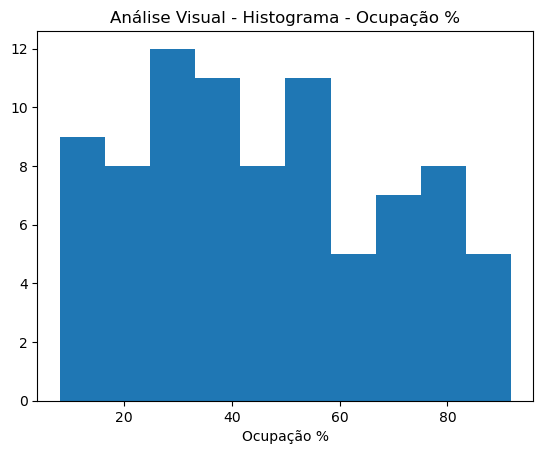

In [69]:
visualizacoes(dados_modelo_percentual_ocupacao, 'percentual_ocupacao', 'Ocupação %')

##### Modelo 2 

In [71]:
concentracao_valores(dados_modelo_prejuizo_lucro, 'prejuizo_lucro')

prejuizo_lucro
True     46
False    38
Name: count, dtype: int64


In [72]:
correlacao_modelos(dados_modelo_prejuizo_lucro, 'prejuizo_lucro')

Menores Valores
----------------------
temperatura                     -0.400751
campeonato_carioca              -0.375615
anunciou_poupar                 -0.350962
eliminatorio                    -0.341418
tipo_partida_volta              -0.330599
time_adversario_Portuguesa-RJ   -0.211741
estádio_Luso Brasileiro         -0.211741
Name: prejuizo_lucro, dtype: float64
Maiores Valores
----------------------
prejuizo_lucro         1.000000
tipo_partida_liga      0.341418
rodada                 0.336500
mes                    0.329091
campeonato_serie a     0.324516
fase_fase de grupos    0.252082
classico               0.237518
Name: prejuizo_lucro, dtype: float64


##### Modelo 3

In [74]:
concentracao_valores(dados_modelo_resultado_partida, 'resultado_partida')

resultado_partida
 1    45
-1    22
 0    17
Name: count, dtype: int64


In [75]:
correlacao_modelos(dados_modelo_resultado_partida, 'resultado_partida')

Menores Valores
----------------------
tecnico_botafogo_Lúcio Flávio   -0.361217
time_adversario_Flamengo        -0.288376
rodada                          -0.253215
classico                        -0.247411
time_adversario_Cuiabá-MT       -0.234018
estado_adversario_MT            -0.234018
mes                             -0.212380
Name: resultado_partida, dtype: float64
Maiores Valores
----------------------
resultado_partida              1.000000
resultados_ultimo_jogo         0.585191
ano_campeonato                 0.312189
gols_botafogo_ultimos_jogos    0.278859
minuto                         0.256856
jogos_no_mes                   0.247548
eliminatorio                   0.207214
Name: resultado_partida, dtype: float64


### Modelagem

##### Modelo 1

In [78]:
X = dados_modelo_percentual_ocupacao.drop(columns=['percentual_ocupacao']).copy()
y = dados_modelo_percentual_ocupacao[['percentual_ocupacao']]

In [79]:
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=42)
eval_set = [(X_test, y_test)]
cat_features = X_test.select_dtypes(exclude=[np.number])

In [80]:
tunning_hiperpametros(CatBoostRegressor, X_train, y_train)

Testando Variáveis: max_depth
0:	learn: 23.5003835	total: 151ms	remaining: 30s
1:	learn: 23.4542175	total: 156ms	remaining: 15.4s
2:	learn: 23.4029466	total: 159ms	remaining: 10.4s
3:	learn: 23.3519790	total: 162ms	remaining: 7.95s
4:	learn: 23.2988481	total: 165ms	remaining: 6.45s
5:	learn: 23.2258818	total: 168ms	remaining: 5.44s
6:	learn: 23.1978147	total: 171ms	remaining: 4.72s
7:	learn: 23.1424544	total: 175ms	remaining: 4.2s
8:	learn: 23.0855136	total: 178ms	remaining: 3.78s
9:	learn: 23.0248297	total: 181ms	remaining: 3.44s
10:	learn: 22.9791349	total: 184ms	remaining: 3.16s
11:	learn: 22.9319242	total: 187ms	remaining: 2.93s
12:	learn: 22.8915337	total: 191ms	remaining: 2.74s
13:	learn: 22.8485833	total: 193ms	remaining: 2.57s
14:	learn: 22.7877219	total: 196ms	remaining: 2.42s
15:	learn: 22.7272473	total: 200ms	remaining: 2.29s
16:	learn: 22.6627107	total: 203ms	remaining: 2.18s
17:	learn: 22.6066082	total: 206ms	remaining: 2.08s
18:	learn: 22.5581843	total: 209ms	remaining: 1

In [81]:
model = CatBoostRegressor(learning_rate=0.01, max_depth=3, n_estimators=10000, random_state=1,  
                     subsample = 0.6)

model.fit(X_train, y_train, eval_set=eval_set, use_best_model=True, early_stopping_rounds=10)

0:	learn: 23.5094462	test: 22.1330586	best: 22.1330586 (0)	total: 4.45ms	remaining: 44.5s
1:	learn: 23.4592984	test: 22.0950073	best: 22.0950073 (1)	total: 9.56ms	remaining: 47.8s
2:	learn: 23.4069048	test: 22.0481416	best: 22.0481416 (2)	total: 13.4ms	remaining: 44.6s
3:	learn: 23.3447588	test: 21.9966652	best: 21.9966652 (3)	total: 18.7ms	remaining: 46.6s
4:	learn: 23.2639320	test: 21.9014060	best: 21.9014060 (4)	total: 22.9ms	remaining: 45.7s
5:	learn: 23.2090727	test: 21.8461951	best: 21.8461951 (5)	total: 26.8ms	remaining: 44.7s
6:	learn: 23.1854735	test: 21.8594273	best: 21.8461951 (5)	total: 33.4ms	remaining: 47.7s
7:	learn: 23.1481890	test: 21.8112941	best: 21.8112941 (7)	total: 36.6ms	remaining: 45.7s
8:	learn: 23.0957971	test: 21.7574071	best: 21.7574071 (8)	total: 40.1ms	remaining: 44.5s
9:	learn: 23.0414651	test: 21.7091042	best: 21.7091042 (9)	total: 44.1ms	remaining: 44.1s
10:	learn: 23.0040891	test: 21.6660414	best: 21.6660414 (10)	total: 48.1ms	remaining: 43.7s
11:	lear

In [82]:
model.feature_importances_

array([1.39564654e+00, 5.30309438e+00, 1.11245875e+00, 4.50713305e+00,
       1.94975702e-01, 1.01084967e+00, 1.34535673e+00, 1.28814795e+00,
       2.26458714e+00, 4.27018840e+00, 8.12791463e-01, 1.52948427e+01,
       1.45146428e+00, 8.42410546e-01, 9.13617101e-01, 1.40649303e+01,
       1.52999901e+00, 2.87737855e+00, 3.18238311e-01, 5.74748059e+00,
       1.84408596e+01, 1.94468221e-01, 9.93175530e-01, 1.72770500e+00,
       1.29970732e-05, 0.00000000e+00, 0.00000000e+00, 1.63871191e-01,
       0.00000000e+00, 7.00708178e-01, 8.16618184e-02, 0.00000000e+00,
       6.14840862e-02, 0.00000000e+00, 1.53152015e+00, 8.03848273e-01,
       2.56118404e-02, 0.00000000e+00, 2.24955980e-04, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 7.16345148e-07, 0.00000000e+00,
       1.62501087e-03, 1.66124561e-01, 0.00000000e+00, 3.22156493e-03,
       1.47970323e-02, 1.49792629e-02, 1.62308762e+00, 7.01578328e-04,
       8.58958583e-03, 3.00176317e-01, 0.00000000e+00, 2.02726518e+00,
      

Text(0.5, 1.0, 'Feature Importance')

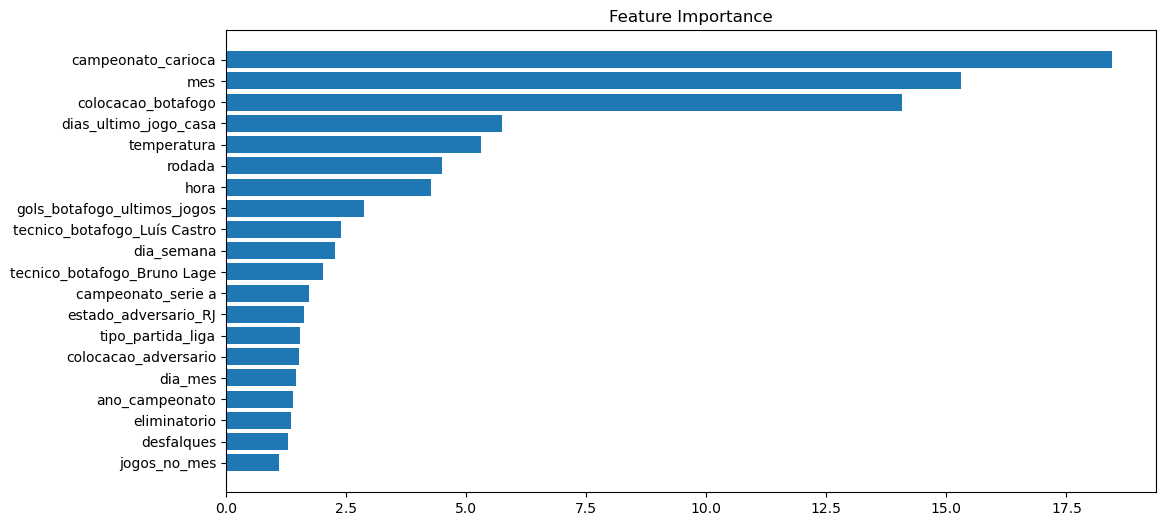

In [83]:
feature_importance = model.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 6))
plt.barh(range(20), feature_importance[sorted_idx][-20:], align='center')
plt.yticks(range(20), np.array(X_test.columns)[sorted_idx][-20:])
plt.title('Feature Importance')

In [84]:
score = model.score(X_train, y_train)  
score

0.5546594820447919

In [85]:
y_pred = model.predict(X_test)
predictions = [round(value, 2) for value in y_pred]
len(predictions)

17

Text(0.5, 1.0, 'Previsão Ocupação')

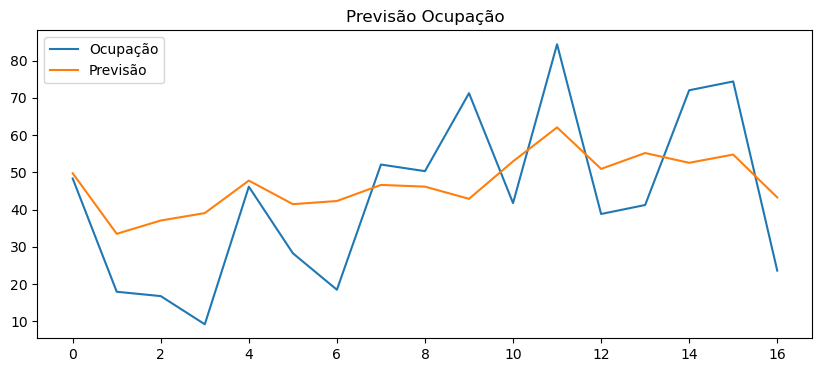

In [86]:
y_test = y_test.reset_index(drop=True)
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(y_test, label='Ocupação')
ax.plot(predictions, label='Previsão')
ax.legend()
ax.set_title("Previsão Ocupação")

In [87]:
taxas_erro(y_test, predictions)

Erro médio quadrático:  17.58023020661695
Erro médio absoluto:  15.410588235294119


##### Previsões

In [89]:
dataset_previsao_modelo = dataset_previsao.drop(columns=['percentual_ocupacao', 'prejuizo_lucro', 'resultado_partida']
                                               ).copy().reset_index(drop=True).loc[:0]

In [90]:
model.predict(dataset_previsao_modelo)

array([49.86806522])

##### Modelo 2

In [92]:
dados_modelo_prejuizo_lucro = dados_modelo_prejuizo_lucro[~dados_modelo_prejuizo_lucro['prejuizo_lucro'].isna() == True].reset_index(drop=True)

In [93]:
X = dados_modelo_prejuizo_lucro.drop(columns=['prejuizo_lucro']).copy()
y = dados_modelo_prejuizo_lucro[['prejuizo_lucro']]

In [94]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
eval_set = [(X_test, y_test)]

In [95]:
tunning_hiperpametros(CatBoostClassifier, X_train, y_train)

Testando Variáveis: max_depth
0:	learn: 0.6892858	total: 7.05ms	remaining: 1.4s
1:	learn: 0.6848308	total: 13.8ms	remaining: 1.36s
2:	learn: 0.6798789	total: 19.7ms	remaining: 1.29s
3:	learn: 0.6765227	total: 26.2ms	remaining: 1.28s
4:	learn: 0.6706100	total: 31.7ms	remaining: 1.24s
5:	learn: 0.6652691	total: 39.2ms	remaining: 1.27s
6:	learn: 0.6603465	total: 44.8ms	remaining: 1.23s
7:	learn: 0.6554262	total: 50.6ms	remaining: 1.21s
8:	learn: 0.6511265	total: 57.9ms	remaining: 1.23s
9:	learn: 0.6462608	total: 63.8ms	remaining: 1.21s
10:	learn: 0.6422322	total: 71.6ms	remaining: 1.23s
11:	learn: 0.6372090	total: 77.5ms	remaining: 1.21s
12:	learn: 0.6330277	total: 82.7ms	remaining: 1.19s
13:	learn: 0.6284562	total: 89.5ms	remaining: 1.19s
14:	learn: 0.6235262	total: 95.8ms	remaining: 1.18s
15:	learn: 0.6196411	total: 102ms	remaining: 1.17s
16:	learn: 0.6145105	total: 108ms	remaining: 1.17s
17:	learn: 0.6089478	total: 112ms	remaining: 1.14s
18:	learn: 0.6034180	total: 119ms	remaining: 1.1

In [96]:
model = CatBoostClassifier(learning_rate=0.01, max_depth=9, n_estimators=10000, random_state=1,  
                     subsample = 0.8)

model.fit(X_train, y_train, eval_set=eval_set, verbose = 1, early_stopping_rounds=10)

0:	learn: 0.6882087	test: 0.6928161	best: 0.6928161 (0)	total: 10ms	remaining: 1m 40s
1:	learn: 0.6819531	test: 0.6925598	best: 0.6925598 (1)	total: 18.6ms	remaining: 1m 32s
2:	learn: 0.6787446	test: 0.6918193	best: 0.6918193 (2)	total: 27.7ms	remaining: 1m 32s
3:	learn: 0.6736022	test: 0.6912400	best: 0.6912400 (3)	total: 36.3ms	remaining: 1m 30s
4:	learn: 0.6686702	test: 0.6901372	best: 0.6901372 (4)	total: 45.7ms	remaining: 1m 31s
5:	learn: 0.6633272	test: 0.6886040	best: 0.6886040 (5)	total: 54.9ms	remaining: 1m 31s
6:	learn: 0.6576886	test: 0.6854018	best: 0.6854018 (6)	total: 63.5ms	remaining: 1m 30s
7:	learn: 0.6519630	test: 0.6840252	best: 0.6840252 (7)	total: 72.1ms	remaining: 1m 30s
8:	learn: 0.6467801	test: 0.6836423	best: 0.6836423 (8)	total: 79ms	remaining: 1m 27s
9:	learn: 0.6427822	test: 0.6821998	best: 0.6821998 (9)	total: 88.1ms	remaining: 1m 27s
10:	learn: 0.6370830	test: 0.6808193	best: 0.6808193 (10)	total: 96.9ms	remaining: 1m 28s
11:	learn: 0.6325597	test: 0.67968

In [97]:
model.feature_importances_

array([2.00258760e+00, 1.01270687e+01, 1.44334667e+00, 5.19608493e+00,
       2.73176395e+00, 2.76632460e+00, 3.50764612e+00, 2.95168130e+00,
       4.56235088e+00, 7.15754959e+00, 4.23007315e+00, 6.13236493e+00,
       2.48147631e+00, 2.27269960e+00, 4.00397553e+00, 7.89323744e+00,
       4.02739653e+00, 2.64276217e+00, 1.72996121e-01, 6.86727609e+00,
       2.14673935e+00, 7.11717774e-06, 1.24957656e-01, 6.60249435e-01,
       7.53369249e-01, 4.29800079e-02, 6.44193515e-03, 2.48192370e-01,
       0.00000000e+00, 1.86848651e-01, 2.50372506e-02, 0.00000000e+00,
       4.46132783e-03, 0.00000000e+00, 4.66485739e+00, 1.31629664e+00,
       4.04671370e-02, 2.10332005e-05, 6.07695887e-03, 0.00000000e+00,
       0.00000000e+00, 7.90836658e-02, 1.32449170e-02, 0.00000000e+00,
       1.86437493e-01, 0.00000000e+00, 7.64605665e-03, 3.24884704e-02,
       2.40915921e-02, 6.06145829e-02, 1.19651542e-01, 4.46338050e-02,
       0.00000000e+00, 2.89428448e-01, 3.20345394e-01, 6.47682570e-02,
      

Text(0.5, 1.0, 'Feature Importance')

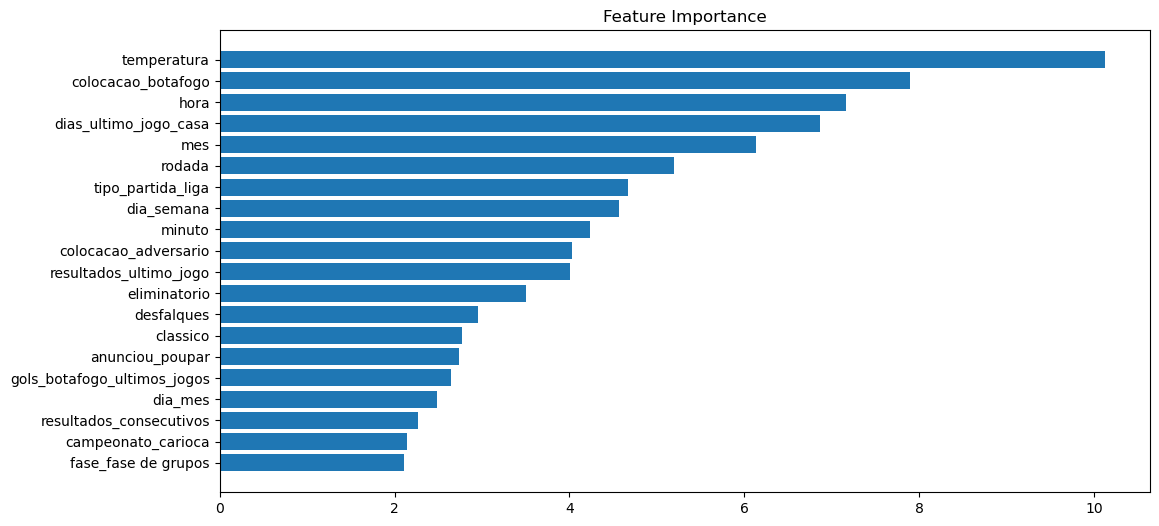

In [98]:
feature_importance = model.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 6))
plt.barh(range(20), feature_importance[sorted_idx][-20:], align='center')
plt.yticks(range(20), np.array(X_test.columns)[sorted_idx][-20:])
plt.title('Feature Importance')

In [99]:
score = model.score(X_train, y_train)  
score

1.0

In [100]:
y_pred = model.predict(X_test)
predictions = [int(value) for value in y_pred]
len(predictions)

17

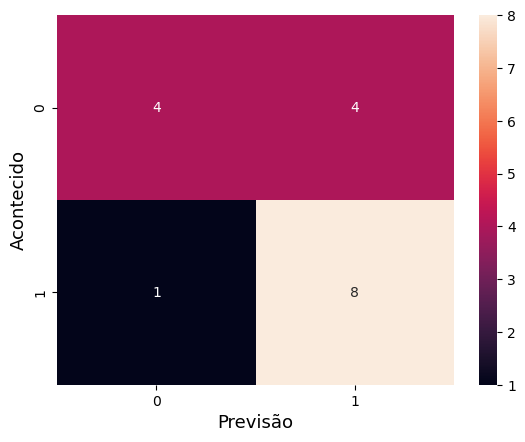

In [101]:
sns.heatmap(confusion_matrix(y_test, predictions), 
            annot=True,
            fmt='g')
plt.ylabel('Acontecido',fontsize=13)
plt.xlabel('Previsão',fontsize=13)
plt.show()

In [102]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

       False       0.80      0.50      0.62         8
        True       0.67      0.89      0.76         9

    accuracy                           0.71        17
   macro avg       0.73      0.69      0.69        17
weighted avg       0.73      0.71      0.69        17



##### Previsões

In [104]:
model.predict(dataset_previsao_modelo)

array([ True])

##### Modelo 3

In [106]:
X = dados_modelo_resultado_partida.drop(columns=['resultado_partida']).copy()
y = dados_modelo_resultado_partida[['resultado_partida']]

In [107]:
y.loc[y[y['resultado_partida'] == -1].index, 'resultado_partida'] = 2

In [108]:
y['resultado_partida'] = y['resultado_partida'].astype(int)

In [109]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
eval_set = [(X_test, y_test)]

In [110]:
tunning_hiperpametros(CatBoostClassifier, X_train, y_train)

Testando Variáveis: max_depth
0:	learn: 1.0941794	total: 1.94ms	remaining: 387ms
1:	learn: 1.0905037	total: 4.12ms	remaining: 408ms
2:	learn: 1.0865228	total: 5.73ms	remaining: 376ms
3:	learn: 1.0842784	total: 7.48ms	remaining: 366ms
4:	learn: 1.0818359	total: 9.81ms	remaining: 383ms
5:	learn: 1.0796539	total: 11.8ms	remaining: 381ms
6:	learn: 1.0774528	total: 14ms	remaining: 386ms
7:	learn: 1.0757873	total: 16ms	remaining: 384ms
8:	learn: 1.0735968	total: 17.9ms	remaining: 381ms
9:	learn: 1.0712447	total: 19.7ms	remaining: 375ms
10:	learn: 1.0682557	total: 21.4ms	remaining: 367ms
11:	learn: 1.0660435	total: 24.1ms	remaining: 377ms
12:	learn: 1.0637182	total: 26ms	remaining: 374ms
13:	learn: 1.0617571	total: 27.9ms	remaining: 370ms
14:	learn: 1.0596376	total: 29.8ms	remaining: 367ms
15:	learn: 1.0575274	total: 32.2ms	remaining: 371ms
16:	learn: 1.0552755	total: 34ms	remaining: 366ms
17:	learn: 1.0531290	total: 35.7ms	remaining: 361ms
18:	learn: 1.0515259	total: 38ms	remaining: 362ms
19

In [111]:
model = CatBoostClassifier(learning_rate=0.01, max_depth=9, n_estimators=10000, random_state=1)

model.fit(X_train, y_train, eval_set=eval_set, verbose = 1, early_stopping_rounds=10)

0:	learn: 1.0956060	test: 1.0969713	best: 1.0969713 (0)	total: 14.1ms	remaining: 2m 21s
1:	learn: 1.0933984	test: 1.0959088	best: 1.0959088 (1)	total: 19.7ms	remaining: 1m 38s
2:	learn: 1.0909542	test: 1.0950566	best: 1.0950566 (2)	total: 35.1ms	remaining: 1m 56s
3:	learn: 1.0881008	test: 1.0934145	best: 1.0934145 (3)	total: 50ms	remaining: 2m 5s
4:	learn: 1.0850463	test: 1.0912478	best: 1.0912478 (4)	total: 61ms	remaining: 2m 1s
5:	learn: 1.0819650	test: 1.0908479	best: 1.0908479 (5)	total: 75.1ms	remaining: 2m 5s
6:	learn: 1.0794326	test: 1.0894390	best: 1.0894390 (6)	total: 94.1ms	remaining: 2m 14s
7:	learn: 1.0773719	test: 1.0882317	best: 1.0882317 (7)	total: 109ms	remaining: 2m 16s
8:	learn: 1.0753602	test: 1.0877473	best: 1.0877473 (8)	total: 124ms	remaining: 2m 17s
9:	learn: 1.0731565	test: 1.0871372	best: 1.0871372 (9)	total: 137ms	remaining: 2m 16s
10:	learn: 1.0714039	test: 1.0859488	best: 1.0859488 (10)	total: 149ms	remaining: 2m 15s
11:	learn: 1.0690305	test: 1.0844191	best

In [112]:
model.feature_importances_

array([3.93849915e+00, 4.23269606e+00, 4.33744056e+00, 4.46448098e+00,
       6.55110975e-02, 2.79374315e+00, 9.08980442e-01, 6.90378819e+00,
       5.59696440e+00, 3.24725625e+00, 2.16043805e+00, 4.66725560e+00,
       7.72576035e+00, 3.54298356e+00, 1.01425399e+01, 3.40158148e+00,
       3.11324907e+00, 6.68298940e+00, 2.43863866e-01, 7.61775560e+00,
       4.23564049e-01, 2.03222184e-01, 2.51769294e-01, 5.08560036e-01,
       1.65613540e+00, 1.02541771e-04, 2.91676062e-03, 1.58501938e-01,
       8.67426445e-04, 3.91670608e-01, 8.89274245e-02, 0.00000000e+00,
       9.34930389e-02, 0.00000000e+00, 7.88683419e-01, 2.33843157e-01,
       3.19399045e-01, 1.05092453e-02, 4.57541347e-03, 0.00000000e+00,
       2.58393391e-02, 1.06509632e-01, 3.60297076e-02, 2.66016376e-02,
       6.76943660e-02, 1.51364399e-01, 1.02223867e-01, 4.27493214e-03,
       1.80692327e-02, 1.23194757e-01, 5.20982135e-01, 8.35214902e-02,
       1.06248645e-02, 3.20281493e-01, 6.17311618e-01, 3.05675726e-01,
      

Text(0.5, 1.0, 'Feature Importance')

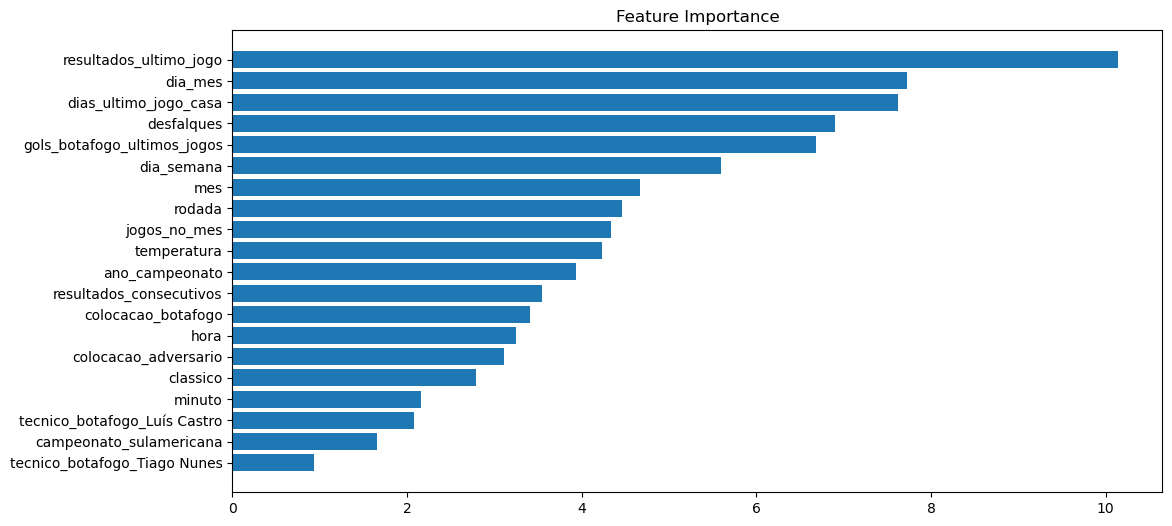

In [113]:
feature_importance = model.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 6))
plt.barh(range(20), feature_importance[sorted_idx][-20:], align='center')
plt.yticks(range(20), np.array(X_test.columns)[sorted_idx][-20:])
plt.title('Feature Importance')

In [114]:
score = model.score(X_train, y_train)  
score

0.9701492537313433

In [115]:
y_pred = model.predict(X_test)
predictions = [int(value) for value in y_pred]
len(predictions)

17

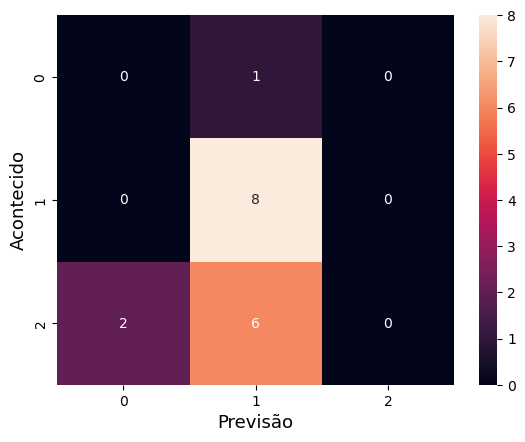

In [116]:
sns.heatmap(confusion_matrix(y_test, predictions), 
            annot=True,
            fmt='g')
plt.ylabel('Acontecido',fontsize=13)
plt.xlabel('Previsão',fontsize=13)
plt.show()

In [117]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.53      1.00      0.70         8
           2       0.00      0.00      0.00         8

    accuracy                           0.47        17
   macro avg       0.18      0.33      0.23        17
weighted avg       0.25      0.47      0.33        17



##### Previsões

In [119]:
model.predict(dataset_previsao_modelo)

array([[2]], dtype=int64)